# Språkprosessering og analyse - Capgeminis CVer

In [367]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import os
import sys
import gensim

In [360]:
sns.set(rc={'figure.figsize':(15, 8)})

In [335]:
cv_path = os.path.join(os.getcwd(), 'data', 'sharepoint', 'cv')
cvs = os.listdir(cv_path)

In [336]:
get_cv = lambda name : os.path.join(cv_path, name)

## Preprosessering

In [338]:
spacy_model = 'nb_core_news_lg'
nlp = spacy.load(spacy_model)
nlp.add_pipe('sentencizer')

In [109]:
def flat_map(xs):
    ys = []
    for x in xs:
        ys.extend(x)
    return ys

def clean_sent(sent):
    escapes = ['\n', '\t', '\r']
    
    def valid(tok):
        return tok not in escapes
    
    for e in escapes:
        sent = sent.replace(e, ' ')
    
    return sent

MIN_LEN = 20        
def get_sentences(data):
    sents = []
    for sent in data:
        # clean the raw text
        cleaned = clean_sent(sent).strip()
        
        # parse possible sub-sentences using spacy
        doc = nlp(cleaned)
        sub_sents = [s.text for s in doc.sents if len(s.text) > MIN_LEN]
        sents.append(sub_sents)
    return flat_map(sents)

In [339]:
all_texts = []
all_labels = []

for cv_name in cvs:
    with open(get_cv(cv_name), 'r', encoding='utf-8') as f:
        data = f.readlines()
        sents = get_sentences(data)
        all_texts.extend(sents)
        labels = len(sents) * [cv_name.replace('.txt', '')]
        all_labels.extend(labels)

## Gjør om til tabulær data

In [279]:
columns = ['text', 'konsulent']
df = pd.DataFrame(list(zip(all_texts, all_labels)), columns=columns)
df

,text,konsulent
0,Albert er en svilingeniør innen kybernetikk og...,albert danielsen
1,Han har opparbeidet seg bred erfaring innen pr...,albert danielsen
2,Nylig har Albert jobbet i et prosjekt for Alte...,albert danielsen
3,Hans bidrag i dette prosjektet består i front-...,albert danielsen
4,i et domain driven design-mønster.,albert danielsen
...,...,...
1383,2019-07 - Microsoft 365 Certified:,vegard walmsness
1384,Administrator Associate,vegard walmsness
1385,Certified Fundamentals,vegard walmsness
1386,Administering and Deploying System Center Conf...,vegard walmsness


In [280]:
sample = df.text[1]
sample

'Han har opparbeidet seg bred erfaring innen programvareutvikling fra sine prosjekter hos tidligere arbeidsgivere og som konsulent.'

In [281]:
doc = nlp(sample)
print([token.lemma_ for token in doc])
print([tok for tok in doc])

['han', 'har', 'opparbeide', 'seg', 'bred', 'erfaring', 'innen', 'programvareutvikling', 'fra', 'sine', 'prosjekt', 'hos', 'tidlig', 'arbeidsgiver', 'og', 'som', 'konsulent', '.']
[Han, har, opparbeidet, seg, bred, erfaring, innen, programvareutvikling, fra, sine, prosjekter, hos, tidligere, arbeidsgivere, og, som, konsulent, .]


In [282]:
def get_ent(ent):
    return [ent.text, ent.start_char, ent.end_char, ent.label_]

def enrich(row):
    doc = nlp(row.text)
    
    lemmas = [token.lemma_ for token in doc]
    row['lemmas'] = lemmas
    
    ents = [get_ent(ent) for ent in doc.ents]
    row['ents'] = ents
    
    tokens = [tok for tok in doc]
    row['tokens'] = tokens
    
    return row

df = df.apply(enrich, axis=1)

In [283]:
df

,text,konsulent,lemmas,ents,tokens
0,Albert er en svilingeniør innen kybernetikk og...,albert danielsen,"[Albert, er, en, svilingeniør, innen, kybernet...","[[Albert, 0, 6, PER], [NTNU, 70, 74, ORG]]","[Albert, er, en, svilingeniør, innen, kybernet..."
1,Han har opparbeidet seg bred erfaring innen pr...,albert danielsen,"[han, har, opparbeide, seg, bred, erfaring, in...",[],"[Han, har, opparbeidet, seg, bred, erfaring, i..."
2,Nylig har Albert jobbet i et prosjekt for Alte...,albert danielsen,"[nylig, har, Albert, jobbe, i, et, prosjekt, f...","[[Albert, 10, 16, PER], [Altera Infrastructure...","[Nylig, har, Albert, jobbet, i, et, prosjekt, ..."
3,Hans bidrag i dette prosjektet består i front-...,albert danielsen,"[hans, bidrag, i, dette, prosjekt, bestå, i, f...","[[Vue, 103, 106, ORG]]","[Hans, bidrag, i, dette, prosjektet, består, i..."
4,i et domain driven design-mønster.,albert danielsen,"[i, et, domain, driven, design-mønster, .]",[],"[i, et, domain, driven, design-mønster, .]"
...,...,...,...,...,...
1383,2019-07 - Microsoft 365 Certified:,vegard walmsness,"[2019-07, -, Microsoft, 365, Certified, :]","[[Microsoft, 10, 19, ORG]]","[2019-07, -, Microsoft, 365, Certified, :]"
1384,Administrator Associate,vegard walmsness,"[administrator, Associate]",[],"[Administrator, Associate]"
1385,Certified Fundamentals,vegard walmsness,"[Certified, Fundamentals]",[],"[Certified, Fundamentals]"
1386,Administering and Deploying System Center Conf...,vegard walmsness,"[Administering, and, Deploying, System, Center...",[],"[Administering, and, Deploying, System, Center..."


In [284]:
def get_texts_from_name(name):
    return list(df[(df.konsulent.str.contains(name))].text)

get_texts_from_name('albert')[:3]

['Albert er en svilingeniør innen kybernetikk og robotikk, utdannet ved NTNU, med spesialisering innen embedded systems.',
 'Han har opparbeidet seg bred erfaring innen programvareutvikling fra sine prosjekter hos tidligere arbeidsgivere og som konsulent.',
 'Nylig har Albert jobbet i et prosjekt for Altera Infrastructure, et stort skipsrederi, med mål om å digitalisere arbeidsflyten ved modifikasjoner på skip i drift.']

In [285]:
STOPPORD = ['gjennom', 'as', 'innen', 'å', 'alle', 'at', 'av', 'både', 'båe', 'bare', 'begge', 'ble', 'blei', 'bli', 'blir', 'blitt', 'då', 'da', 'de', 'deg', 'dei', 'deim', 'deira', 'deires', 'dem', 'den', 'denne', 'der', 'dere', 'deres', 'det', 'dette', 'di', 'din', 'disse', 'ditt', 'du', 'dykk', 'dykkar', 'eg', 'ein', 'eit', 'eitt', 'eller', 'elles', 'en', 'enn', 'er', 'et', 'ett', 'etter', 'før', 'for', 'fordi', 'fra', 'ha', 'hadde', 'han', 'hans', 'har', 'hennar', 'henne', 'hennes', 'her', 'hjå', 'ho', 'hoe', 'honom', 'hoss', 'hossen', 'hun', 'hva', 'hvem', 'hver', 'hvilke', 'hvilken', 'hvis', 'hvor', 'hvordan', 'hvorfor', 'i', 'ikke', 'ikkje', 'ingen', 'ingi', 'inkje', 'inn', 'inni', 'ja', 'jeg', 'kan', 'kom', 'korleis', 'korso', 'kun', 'kunne', 'kva', 'kvar', 'kvarhelst', 'kven', 'kvi', 'kvifor', 'man', 'mange', 'me', 'med', 'medan', 'meg', 'meget', 'mellom', 'men', 'mi', 'min', 'mine', 'mitt', 'mot', 'mykje', 'nå', 'når', 'ned', 'no', 'noe', 'noen', 'noka', 'noko', 'nokon', 'nokor', 'nokre', 'og', 'også', 'om', 'opp', 'oss', 'over', 'på', 'så', 'sånn', 'samme', 'seg', 'selv', 'si', 'sia', 'sidan', 'siden', 'sin', 'sine', 'sitt', 'sjøl', 'skal', 'skulle', 'slik', 'so', 'som', 'somme', 'somt', 'til', 'um', 'upp', 'ut', 'uten', 'vår', 'være', 'vært', 'var', 'vart', 'varte', 'ved', 'vere', 'verte', 'vi', 'vil', 'ville', 'vore', 'vors', 'vort']
len(STOPPORD)

175

In [286]:
NAVN = [cv.replace('.txt', '').split() for cv in cvs]
NAVN = flat_map(NAVN)

In [287]:
FY_ORD = []
FY_ORD.extend(STOPPORD)
FY_ORD.extend(NAVN)

In [288]:
corpus = [tok.text.lower() for tok in flat_map(list(df.tokens)) if len(tok) > 1]
len(corpus)

14666

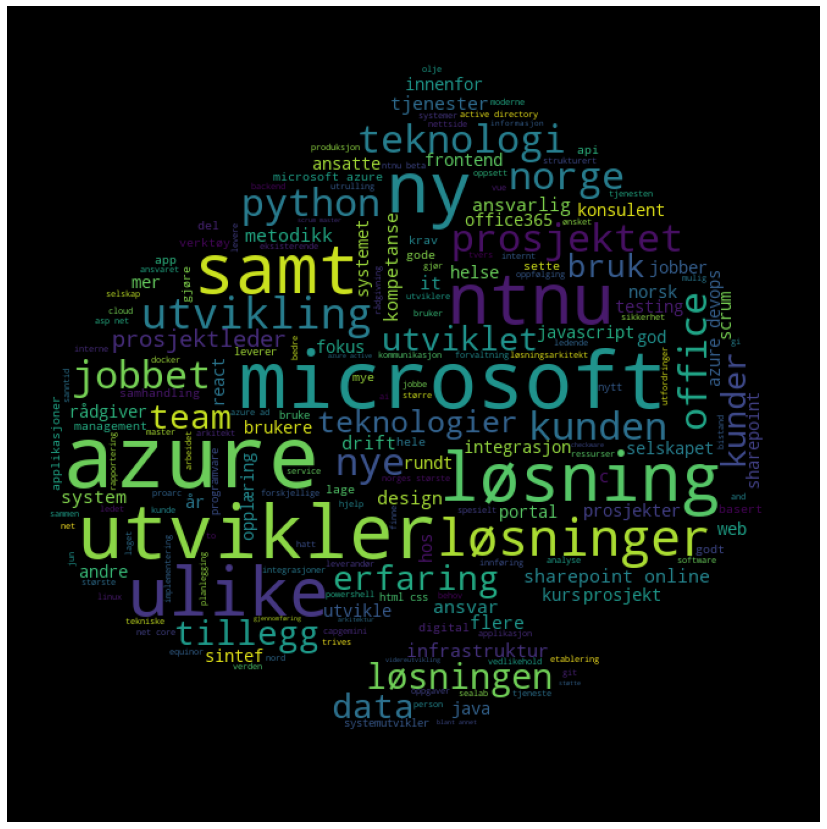

In [345]:
from PIL import Image

logo_path = os.path.join(os.getcwd(), 'data', 'cap.jpg')
generated_logo_path = os.path.join(os.getcwd(), 'data', 'cap-cloud.jpg')
cap_mask = np.array(Image.open(logo_path))

def create_masked_wc(data):
    wc = WordCloud(background_color="black",
                   max_words=200,
                   max_font_size=70,
                   mask=cap_mask,
                   stopwords=FY_ORD,
                   contour_width=0,
                   width=1000,
                   height=1000)

    wc.generate(' '.join(data))

    # store to file
    # wc.to_file(generated_logo_path)

    # show
    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

create_masked_wc(corpus)

In [346]:
lemmas = [' '.join(x) for x in list(df.lemmas)]
ents = [e for e in list(df.ents) if len(e) > 0]
ents = [e[0] for e in flat_map(ents)]
ents[:10]

['Albert',
 'NTNU',
 'Albert',
 'Altera Infrastructure',
 'Vue',
 'Azure DevOps',
 'Albert',
 'Sjøfartsdirektoratet',
 'APS',
 'Personell Sertifikat']

# Med entiteter

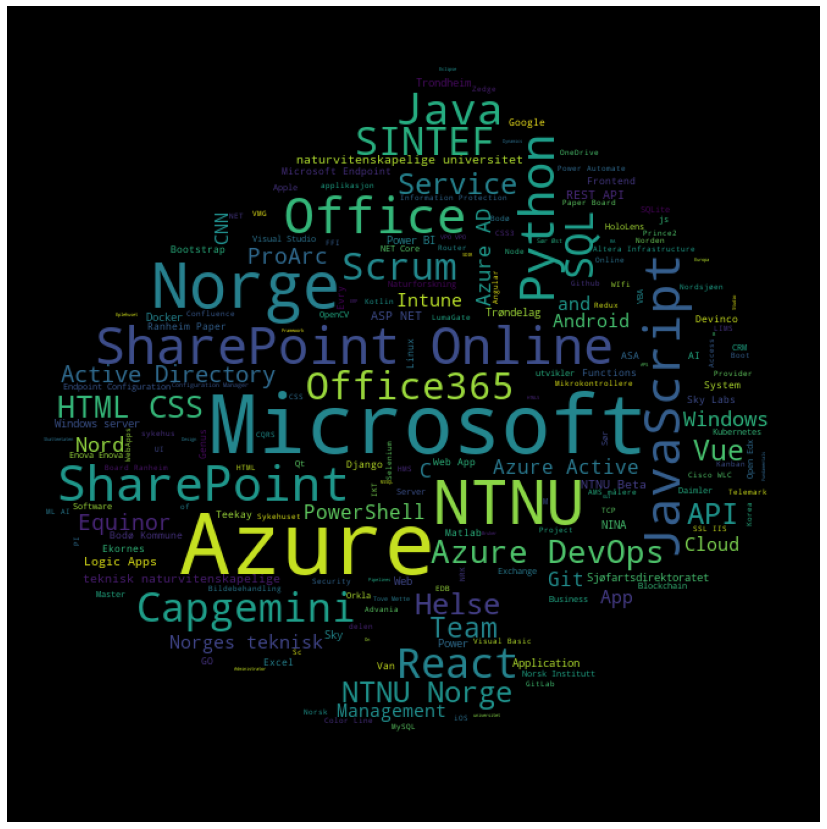

In [347]:
create_masked_wc(ents)

## n-grams

In [348]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [354]:
ngram = get_top_ngram(lemmas, 2)
ngram

[('er en', 47),
 ('office 365', 30),
 ('og teknologi', 28),
 ('er et', 28),
 ('ansvar for', 26),
 ('sharepoint online', 25),
 ('ansvarlig for', 22),
 ('bruk av', 21),
 ('utvikling av', 20),
 ('metodikk og', 20)]

In [355]:
trigram = get_top_ngram(lemmas, 3)
trigram

[('metodikk og teknologi', 16),
 ('ha ansvar for', 10),
 ('ved hjelp av', 9),
 ('sette seg inn', 9),
 ('på tvers av', 8),
 ('azure active directory', 8),
 ('og utvikling av', 7),
 ('norges teknisk naturvitenskapelig', 7),
 ('teknisk naturvitenskapelig universitet', 7),
 ('er norges størst', 7)]

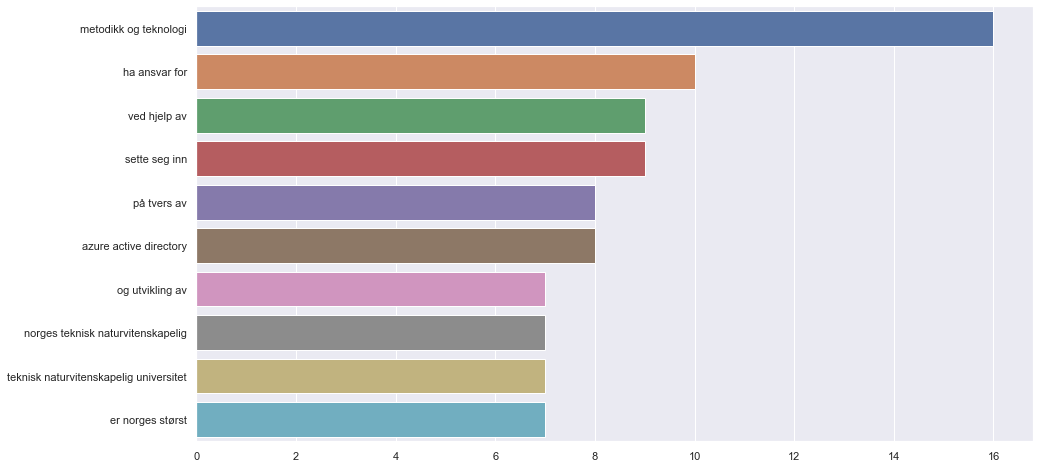

In [364]:
from collections import Counter

def plot_grams(data, n=20):
    x, y = [], []
    for word,count in data:
        if (word.lower() not in FY_ORD):
            x.append(count)
            y.append(word)

    sns.barplot(x=x[:n], y=y[:n])

plot_grams(trigram, 30)

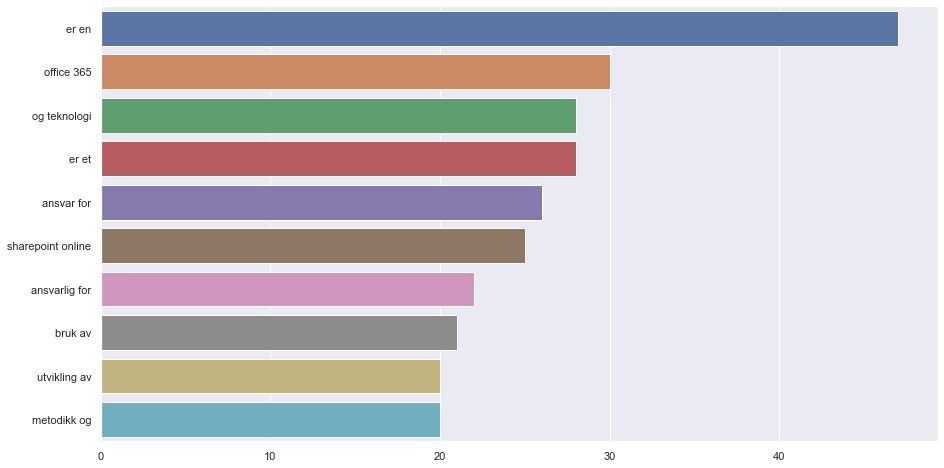

In [365]:
plot_grams(ngram, 30)

## Topic modeling

In [384]:
all_toks = [tok for tok in list(df.tokens) if tok not in STOPPORD and len(tok) > 1]
all_toks[0]

[Albert,
 er,
 en,
 svilingeniør,
 innen,
 kybernetikk,
 og,
 robotikk,
 ,,
 utdannet,
 ved,
 NTNU,
 ,,
 med,
 spesialisering,
 innen,
 embedded,
 systems,
 .]

In [397]:
bow = []
for grouped_tok in list(df.tokens):
    parsed = []
    for tok in grouped_tok:
        if len(tok) > 1 and tok.text not in STOPPORD:
            parsed.append(tok.text.lower())
    bow.append(parsed)

In [398]:
gen_corp = gensim.corpora.Dictionary(bow)
bow_corpus = [gen_corp.doc2bow(doc) for doc in bow]

In [400]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = gen_corp,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.015*"azure" + 0.008*"microsoft" + 0.008*"ntnu" + 0.006*"teknologi" + 0.005*"power" + 0.005*".net" + 0.005*"devops" + 0.005*"sharepoint" + 0.004*"python" + 0.004*"apps"'),
 (1,
  '0.011*"azure" + 0.008*"utvikler" + 0.005*"design" + 0.005*"løsninger" + 0.005*"prosjektet" + 0.005*"han" + 0.004*"ulike" + 0.004*"microsoft" + 0.004*"utvikling" + 0.004*"kompetanse"'),
 (2,
  '0.010*"as" + 0.009*"største" + 0.006*"norge" + 0.006*"norges" + 0.006*"ny" + 0.005*"erfaring" + 0.005*"teknologier" + 0.005*"ntnu" + 0.004*"universitet" + 0.004*"sky"'),
 (3,
  '0.011*"365" + 0.009*"office" + 0.008*"azure" + 0.007*"microsoft" + 0.007*"sharepoint" + 0.007*"han" + 0.005*"online" + 0.004*"samt" + 0.004*"utviklet" + 0.004*"god"')]

In [408]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, gen_corp)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.088006  0.005408       1        1  27.486876
2      0.132668 -0.003999       2        1  25.243601
1     -0.027024 -0.104594       3        1  24.435461
0     -0.017638  0.103185       4        1  22.834063, topic_info=         Term       Freq      Total Category  logprob  loglift
338       365  33.000000  33.000000  Default  30.0000  30.0000
160   største  24.000000  24.000000  Default  29.0000  29.0000
339    office  29.000000  29.000000  Default  28.0000  28.0000
50      azure  87.000000  87.000000  Default  27.0000  27.0000
186        as  39.000000  39.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
12        han   7.810979  42.034324   Topic4  -5.7028  -0.2060
490   ansatte   5.739420  13.633486   Topic4  -6.0110   0.6117
11   erfaring   6.431439  27.133813   Topic4  -5.8971   0.0373
39    løsning   6.267487  25.120230   Topic4  -5.9229   0.0886
168        ny   6.147578  30.782069   Topic4  -5.9423  -0.1340

[275 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
32        1  0.074042        .net
32        2  0.074042        .net
32        4  0.814458        .net
1125      1  0.681856  2008/2012.
578       2  0.624947     2017-08
...     ...       ...         ...
577       1  0.803058     windows
577       2  0.160612     windows
3125      3  0.695013       zedge
568       2  0.348466         øke
568       3  0.696933         øke

[444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [417]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline

In [416]:
model_name = "ltgoslo/norbert"
model = AutoModel.from_pretrained(model_name)

In [420]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [421]:
import torch

In [423]:
from transformers import Trainer, TrainingArguments

In [424]:
import json

In [425]:
data = {}
for json_data in ["train", "test"]:
    with open("{0}.json".format(json_data)) as infile:
        data[json_data] = json.load(infile)